# Iterative Null Space projection

A base implementation using the debias function from https://github.com/shauli-ravfogel/nullspace_projection/tree/master/src. 

Original paper: Null It Out: Guarding Protected Attributes by Iterative Nullspace Projection, S.Ravfogel et al, 2019. 

Further experiments are outlined in: Study on Iterative Nullspace Projection Debiasing of Multiple Attributes of Word Embeddings, X.Zhang, 2022.
 
Given a set of word embeddings $X = \{x_1, x_2, \ldots, x_n\}$, $x_i \in \mathbb{R}^d$, such as professions (doctor, nurse, teacher etc) and attributes $Z = \{z_1, z_2, \ldots, z_n\}$, such as instances of gender (male, female, man, woman etc), we aim to find a transformation $g$ such that $z_i$ cannot be predicted from $g(x_i)$. The first step of INLP is, if we have a classifier $c$ used to predict a persons profession based on some text, we build an auxiliary model $c'$ to predict their gender from the text.

If $c'$ is a classifier with parameters $W$ (e.g. the weights in a deep learning model), we want a projection matrix $P$ such that $W(Pz)=0$ for all $z$, rendering the paramters $W$ useless on $Z$. 

Additional classifiers $W'$ are then trained until no linear information regading $Z$ remains in $X$. $P$ is constructed using nullspace projection, detailed implementation can be found in the original paper. In other words, we train our auxiliary model $c'$ until it predicts the protected attribute from the input text no better than randomly guessing, i.e. $\leq50 \%$ accuracy. The projection matrix is then applied to the embeddings used to train the original model with the hope that the dependency of the sensitive attribute with respect to the output is removed.

The relationship between $W$ and an input $x$ is that $x$ is projected onto the sub-space of the rows of $W$ and is classified by taking the dot product between $W$ and the components of its rows. Therefore if we zero the components of $x$ in the direction of $W's$ rowspace, we remove the information within $W$ used to make a predcition based on $x$, i.e. the ability to make a prediction based on a sensitive attribute in the set $X$. 

Algebraically this is equaivalent to projecting $x$ onto the nullspace of $W$, $N(W)$:
$$
N(W) = \{ x \mid Wx = 0 \}
$$

In summary, for a task where we are predicting a feature $x_i \in X$ from a text sample containing sensitive features $z_i \in Z$, using a classifier $c$, e.g. a person's profession from text containing information about said person, we make a new classifier $c'$ to predict the person's gender (or any other sensitive attribute we want to protect) from the text, and use this to create a projection matrix which is applied to the original text data embeddings, removing the classifiers ability to use gender information when making a prediction.

In [1]:
# Main imports

import old_debias
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
import tensorflow as tf
import tensorflow_hub as hub
import seaborn as sns

Importing Universal Sentence Encoder

We use [Universal Sentence Encoder](https://www.tensorflow.org/hub/tutorials/semantic_similarity_with_tf_hub_universal_encoder) (USE) to generate word embeddings. It is a model which takes a string of text as input and returns a vector containing the word embeddings for the input. These word embeddings will be used to train a classifier to predict the risk based on the prompt, and later for the generation of the projection matrix. 

In [14]:
# Import USE
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)
print ("module %s loaded" % module_url)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [15]:
def embed(input):
  return model(input)

Loading bias in media dataset, which can be found [here](https://github.com/Media-Bias-Group/Neural-Media-Bias-Detection-Using-Distant-Supervision-With-BABE/tree/main/data) as 'final_labels_SG1'

In [3]:
df=pd.read_csv("../data/final_labels_SG1.csv")
df.head()

,text,news_link,outlet,topic,type,label_bias,label_opinion,biased_words
0,The Republican president assumed he was helpin...,http://www.msnbc.com/rachel-maddow-show/auto-i...,msnbc,environment,left,Biased,Expresses writer’s opinion,[]
1,Though the indictment of a woman for her own p...,https://eu.usatoday.com/story/news/nation/2019...,usa-today,abortion,center,Non-biased,Somewhat factual but also opinionated,[]
2,Ingraham began the exchange by noting American...,https://www.breitbart.com/economy/2020/01/12/d...,breitbart,immigration,right,No agreement,No agreement,['flood']
3,The tragedy of America’s 18 years in Afghanist...,http://feedproxy.google.com/~r/breitbart/~3/ER...,breitbart,international-politics-and-world-news,right,Biased,Somewhat factual but also opinionated,"['tragedy', 'stubborn']"
4,The justices threw out a challenge from gun ri...,https://www.huffpost.com/entry/supreme-court-g...,msnbc,gun-control,left,Non-biased,Entirely factual,[]


Checking the number of instances for each topic appear in the dataset. We want to identify which of them are potentially sensitive and isolate them.

In [4]:
print(df['topic'].value_counts())
print(df['label_bias'].value_counts())

topic
environment                              135
white-nationalism                        131
gender                                   128
student-debt                             127
abortion                                 126
sport                                    126
gun-control                              124
immigration                              122
vaccines                                 122
coronavirus                              122
trump-presidency                         120
middle-class                             118
elections-2020                           111
international-politics-and-world-news     88
Name: count, dtype: int64
label_bias
Non-biased      800
Biased          746
No agreement    154
Name: count, dtype: int64


We decide that gender and immigration are sensitive topics. We make a new dataframe containing rows whose topic are gender or immigration.

In [5]:
df_gender = df[df['topic'].str.contains('gender')]
df_immigration = df[df['topic'].str.contains('immigration')]

df_main = pd.concat([df_gender,df_immigration], axis=0)
df_main = df_main.sample(n=len(df_main)) # Shuffle rows
df_main = df_main.reset_index(drop=True)  # Reset indexing
df_main.index = df_main.index + 1 
df_main

,text,news_link,outlet,topic,type,label_bias,label_opinion,biased_words
1,Polling for the Democratic nomination tells a ...,https://www.alternet.org/2019/04/of-course-a-w...,alternet,gender,left,Biased,Somewhat factual but also opinionated,['depressing']
2,"However, much discrimination in today’s workpl...",https://www.alternet.org/2019/01/heres-why-wom...,alternet,gender,left,Non-biased,No agreement,[]
3,Top Democrat and GOP members of the House Arme...,NaN,breitbart,gender,right,Biased,Somewhat factual but also opinionated,"['ducked', 'and', 'dodged', 'claimed']"
4,Six Republican Senators have failed to develop...,https://www.breitbart.com/politics/2019/01/11/...,breitbart,immigration,right,Biased,Somewhat factual but also opinionated,"['illegal', 'aliens']"
5,"Since then, drip by drip, other parts of the f...",https://www.nbcnews.com/feature/nbc-out/trump-...,msnbc,gender,left,No agreement,Entirely factual,['drip']
...,...,...,...,...,...,...,...,...
246,Celebrity activist Alyssa Milano declared at a...,https://www.breitbart.com/entertainment/2019/0...,breitbart,gender,right,Non-biased,Entirely factual,[]
247,Two years after filling the streets of U.S. ci...,https://www.reuters.com/article/us-usa-trump-w...,reuters,gender,center,Non-biased,Entirely factual,[]
248,"On top of the enormous financial impact, these...",https://www.alternet.org/2019/10/the-real-scan...,alternet,gender,left,No agreement,Expresses writer’s opinion,['enormous']
249,After the airstrike that killed Iranian Gen. Q...,https://eu.usatoday.com/story/news/politics/20...,usa-today,immigration,center,Non-biased,Entirely factual,[]


Embedding and encoding the data using USE. At the moment we are processing the entire dataset due to the small size of the data.

In [6]:
text = df['text'].tolist()
bias = df['label_bias']
text_embeddings = embed(text)
print(tf.shape(text_embeddings))

tf.Tensor([1700  512], shape=(2,), dtype=int32)


In [7]:
# Convert tensor into NumPy array
text_embeddings_np = text_embeddings.numpy()

le = LabelEncoder()
bias_encoded = le.fit_transform(bias)


**Model training**

Training a model to predict the bias based on the text embeddings, using various models. We find the SVM produces the highest accuracy over an average of 10 models. Note this is predicting whether the text is biased based on the text, using the entire dataset (1700 rows)

In [8]:
models = {
    #"Logistic Regression": LogisticRegression(),
    #"Random Forest": RandomForestClassifier(),
    #"Gradient Boosting": GradientBoostingClassifier(),
    #"Neural Network": MLPClassifier(hidden_layer_sizes=(200,), max_iter=250),
    #"XGBoost": xgb.XGBClassifier(),
    "SVM": SVC(kernel='linear')
}

results = {}

for model_name, classifier in models.items():
    accuracies = []
    for _ in range(10):
        X_train, X_test, y_train, y_test = train_test_split(text_embeddings_np, bias_encoded, test_size=0.1)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        accuracies.append(acc)
    average_accuracy = np.mean(accuracies)
    results[model_name] = average_accuracy

for model_name, avg_accuracy in results.items():
    print(f"{model_name}: Average Accuracy over 10 iterations: {avg_accuracy}")

SVM: Average Accuracy over 10 iterations: 0.6341176470588236


We now want to debias the dataset according to the two sensitive topics we defined above, gender and immigration. We use the smaller dataframe with the other topics removed. As before we encode and embed the data.

In [16]:
text_debias = df_main['text'].tolist()
bias_debias = df_main['label_bias']
topic_debias = df_main['topic']
le = LabelEncoder()
bias_debias_encoded = le.fit_transform(bias_debias)
topic_debias_encoded = le.fit_transform(topic_debias)
text_embeddings_debias = embed(text_debias)
text_embeddings_debias_np = text_embeddings_debias.numpy()


**Debiasing**

We now perform debiasing by training another model to predict the sensitive features (immigration/gender) on the text to obtain a projection matrix $P$

In [17]:
X_train_topic, X_test_topic, y_train_topic, y_test_topic = train_test_split(text_embeddings_debias_np, topic_debias_encoded, test_size = 0.1, shuffle = False, stratify = None)

In [18]:
# Get projection matrix
def get_projection_matrix(num_clfs, X_train, y_train, X_test, y_test, y_train_main, y_test_main, dim=300):
    is_autoregressive = True
    reg = "l2"
    min_acc = 0.
    noise = False
    random_subset = False
    regression = False
    
    clf = SGDClassifier
    params = {'warm_start': True, 'loss': 'log_loss', 'n_jobs': 64, 'max_iter': 100, 'random_state': 0}

    P = old_debias.get_debiasing_projection(clf, params, num_clfs, dim, is_autoregressive,
                                           min_acc, X_train, y_train, X_test, y_test,
                                           by_class=True, y_train_main=y_train_main, y_test_main=y_test_main)
    return P

num_clfs = 40
y_test_topic = np.array(y_test_topic)
y_train_topic = np.array(y_train_topic)
y_test = np.array(y_test)
y_train = np.array(y_train)

n_examples = 250

In [19]:
P = get_projection_matrix(200, X_train_topic[:n_examples],
                          y_train_topic[:n_examples], X_test_topic[:n_examples], y_test_topic[:n_examples],
                             y_train[:n_examples], y_test[:n_examples], dim = 512)

iteration: 199, accuracy: 0.36: 100%|██████████| 200/200 [00:59<00:00,  3.35it/s]


Applying the projection matrix $P$ to the embedded data and training another classiifer on the debiased data

In [20]:
# Apply projection matrix to embeddings
projected_embeddings = text_embeddings_debias_np.dot(P)

In [21]:
accuracies = []
for _ in range(20):
    # Split dataset
    X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(projected_embeddings, bias_debias_encoded, test_size=0.1)
    
    # Initialise classifier
    clf = SVC(kernel='linear')
    
    # Fit classifier
    clf.fit(X_train_p, y_train_p)
    
    # Predictions
    y_pred_p = clf.predict(X_test_p)
    
    # Calculate accuracy and store it
    acc = accuracy_score(y_test_p, y_pred_p)
    accuracies.append(acc)

average_accuracy = np.mean(accuracies)

print(f"Average accuracy: {average_accuracy}")

Average accuracy: 0.4619999999999999


**Semantic Similarities between sentences**

In [22]:
# Defining plotting functions from USE documentation
def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")

def run_and_plot(messages_):
  message_embeddings_ = embed(messages_)
  plot_similarity([1,2,3], message_embeddings_, 90)

In [23]:
# Visualise dataframe to pick out some sentences
df_main[0:50]

,text,news_link,outlet,topic,type,label_bias,label_opinion,biased_words
1,Polling for the Democratic nomination tells a ...,https://www.alternet.org/2019/04/of-course-a-w...,alternet,gender,left,Biased,Somewhat factual but also opinionated,['depressing']
2,"However, much discrimination in today’s workpl...",https://www.alternet.org/2019/01/heres-why-wom...,alternet,gender,left,Non-biased,No agreement,[]
3,Top Democrat and GOP members of the House Arme...,NaN,breitbart,gender,right,Biased,Somewhat factual but also opinionated,"['ducked', 'and', 'dodged', 'claimed']"
4,Six Republican Senators have failed to develop...,https://www.breitbart.com/politics/2019/01/11/...,breitbart,immigration,right,Biased,Somewhat factual but also opinionated,"['illegal', 'aliens']"
5,"Since then, drip by drip, other parts of the f...",https://www.nbcnews.com/feature/nbc-out/trump-...,msnbc,gender,left,No agreement,Entirely factual,['drip']
6,Violence against women has plagued Mexico for ...,https://www.nbcnews.com/news/latino/shooting-d...,msnbc,gender,left,No agreement,Entirely factual,[]
7,"In Spain, hundreds of thousands of women, wear...",https://www.reuters.com/article/us-womens-day/...,reuters,gender,center,Non-biased,Entirely factual,[]
8,With just over a year left in President Donald...,https://www.nbcnews.com/feature/nbc-out/trump-...,msnbc,gender,left,Non-biased,Entirely factual,[]
9,Elizabeth Warren and Bernie Sanders disagreed ...,https://www.reuters.com/article/us-usa-electio...,reuters,gender,center,Non-biased,No agreement,[]
10,Women in power must pay a significant tax on t...,https://www.alternet.org/2019/10/the-real-scan...,alternet,gender,left,Non-biased,Expresses writer’s opinion,[]


Semantic similarities before debiasing. We have picked 3 sentences,  number 2, 43 and 42 from the list above. 

Sentence 2: **A year after a Democratic wave swept an unprecedented number of women and people of color into higher office all across America, and at a time when Trump’s approval rating is cratering, women should not be afraid of nominating another woman to drive Trump and his brand of pig-headed patriarchy out of the Oval Office.**

topic: gender, biased, contains two biased words "cratering" and "pig-headed"

Sentence 43: **Borrowing from Hillary Clinton, leftist Italian media have labeled those attending the pro-family Congress a “list of deplorables,” calling pro-life and pro-family advocates “neofascists” and “homophobes.”**

topic: gender, biased, contains one biased word "leftist"

Sentence 42: **The Roman Catholic Church allows only men to be ordained as priests and women have traditionally been consigned to the shadows of its administration.**

topic: gender, non-biased, contains no biased words


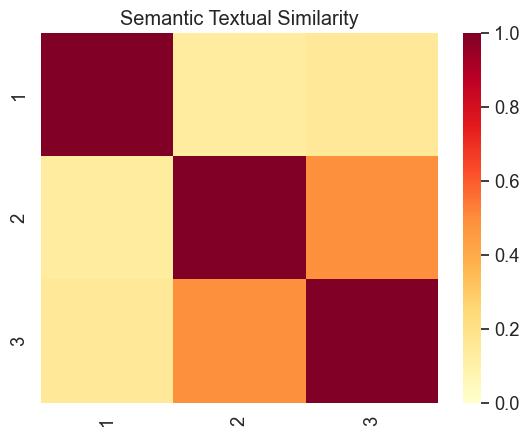

In [24]:
messages = [text_embeddings[2], text_embeddings[43], text_embeddings[42]]
plot_similarity([1,2,3],messages,90)

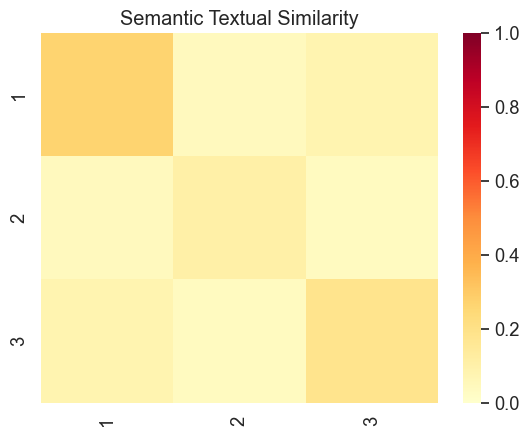

In [25]:
messages_debiased  = [projected_embeddings[2], projected_embeddings[43], projected_embeddings[42]]
plot_similarity([1,2,3],messages_debiased,90)

Manual debiasing by removing the biased words

In [26]:
sentence_1 = df_main['text'][2]
print(sentence_1)

sentence_1d = 'A year after a Democratic wave swept an unprecedented number of women and people of color into higher office all across America, and at a time when Trump’s approval rating is _, women should not be afraid of nominating another woman to drive Trump and his brand of patriarchy out of the Oval Office.'

However, much discrimination in today’s workplace is not intentional but fueled by unconscious gender stereotypes.


In [27]:
sentence_2 = df_main['text'][43]
print(sentence_2)
sentence_2d = 'Borrowing from Hillary Clinton, Italian media have labeled those attending the pro-family Congress a “list of deplorables,” calling pro-life and pro-family advocates “neofascists” and “homophobes.”'

Thousands of asylum seekers crammed in border towns near the Texas-Mexico border awaiting U.S. immigration hearings are at risk of dying from coronavirus because of poor health access and unsafe conditions, advocates say.


In [28]:
sentence_3 = df_main['text'][42]
print(sentence_3)

The travel ban would not have prevented the country’s deadliest terrorist attacks in recent years, which were committed by right-wing Americans, not immigrants: the anti-immigrant extremist who killed 22 shoppers at a store in El Paso; the white supremacist who killed 17 students and teachers at a school in Parkland, Florida; or the anti-Semite who killed 11 worshipers at a synagogue in Pittsburgh.


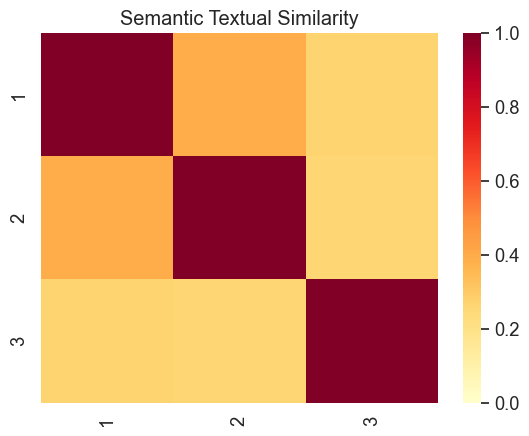

In [29]:
messages_manual_debias = [sentence_1d, sentence_2d, sentence_3]
run_and_plot(messages_manual_debias)